In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def weight_init(experts,opening,method,ticker):
    #add market cap initialization
    if method == 'equal':
        w = np.ones(experts)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return w
    
    if method == 'marketcap':
        caps_dict = pd.read_csv('marketcapdata.csv', index_col='Name').to_dict()['Market Cap']
        w = []
        
        for ticker in tickers:
            try:
                w += caps_dict[ticker]
            except:
                w += 0
                
        return np.array(w).astype('float64')
    

def losses(opening,closing,method):
    if method == 'absolute': #absolute return (close-open)
        return -1*(closing-opening)
    
    elif method=='pricerel': #price relative #closing over opening
        try:
            return -1*(closing/opening-1)
        except:
            return 0
    elif method==3: #beta
        return 1

In [3]:
def mwu(filename,lossmethod,weightmethod):
    #data is a T by N matrix with each row being the returns of each expert i at time t
    data = pd.read_excel(filename)[::-1]
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    tickers = opening.columns
    dates = opening.index.values
    #print(dates)
    #return 0
#     returns = pd.DataFrame()
#     for i in range(len(opening.columns)):
#         tick = closing.iloc[:,i].name[:4]
#         returns[tick]=closing.iloc[:,i]-opening.iloc[:,i]
    
#     pricerel = pd.DataFrame()
#     for i in range(len(opening.columns)):
#         tick = closing.iloc[:,i].name[:4]
#         pricerel[tick]=closing.iloc[:,i]/opening.iloc[:,i]
    
    T = len(data)
    N = len(opening.columns)
    epsilon = np.sqrt(np.log(N)/T) 
   
    w = weight_init(N,opening,weightmethod, tickers)
    p = w/sum(w)
    
    start = 10000000
    #start_open = opening.iloc[0].values
    #return start_open
    #start_quant = []
    #for j,k in enumerate(start_open):
        #print(p[j]*start)
     #   if k == 0:
            #start_quant.append(0)
      #  elif p[j] != 0:
            #start_quant.append((p[j]*start)/k)
       # else:
        #    start_quant.append(0)
    #print(start_quant*start_open)

    quantities = [] #$/prices = quantity of each
    #return quantities

    probs = [p]
    values =[]
    transaction = []
    
    total = T-1 if (lossmethod=='pricerel') else T
    
    for t in range(total):
        #find new prices for the day
        #opening_prices_na = opening.iloc[t]
        #closing_prices_na = closing.iloc[t]
        if lossmethod=='absolute':
            opening_prices = opening.iloc[t].values
            opening_prices[opening.iloc[t].isnull()] = 0
            closing_prices = closing.iloc[t].values
            closing_prices[closing.iloc[t].isnull()] = 0
        elif lossmethod=='pricerel':
            opening_prices = opening.iloc[t-1].values
            opening_prices[opening.iloc[t-1].isnull()] = 0
            closing_prices = opening.iloc[t].values
            closing_prices[opening.iloc[t].isnull()] = 0
            
        if 0 not in opening_prices:
            w[w==0] = 1
    
        #return opening_prices
        
        #portfolio value
        if t==0: 
            values.append(start)
        else:
            values.append(np.sum(np.array(opening_prices)*np.array(quantities[t-1]))) #new opening value
        #print(t)
        q_t = []
        for j,k in enumerate(opening_prices):
            if k == 0:
                q_t.append(0)
            elif p[j] != 0:
                try:
                    q_t.append((p[j]*values[t])/k)
                except:
                    q_t.append(0)
            else:
                q_t.append(0)
        quantities.append(q_t)

        loss = losses(opening_prices,closing_prices,lossmethod) 
        loss[np.isnan(loss)] = 0
        M = max(abs(loss))
        try:
            loss = losses(opening_prices,closing_prices,lossmethod)/M
        except:
            loss = losses(opening_prices,closing_prices,lossmethod)
        loss[np.isnan(loss)] = 0
                
        #check sum of weight updates
        money_moved = sum(np.absolute([-p[i]*epsilon*loss[i] for i in range(N)]))*values[t]
        
        if t==0 or values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(1-epsilon*loss[i])
            transaction.append((t,0.015*money_moved))
        #print(w,transaction)
        
       
        p = w/sum(w)
        probs.append(p)
        #return p

        
    if lossmethod=='pricerel':
        out = pd.DataFrame(probs[1:],columns=tickers,index=dates[:-1])
    elif lossmethod=='absolute':
        out = pd.DataFrame(probs[1:],columns=tickers,index=dates)
    #print(out)
    out['Values'] = values
    out.to_csv(f'mwu_weights_return_{weightmethod}_{lossmethod}_{filename[:-5]}.csv')
    print('Final distribution: ',p)
    print('Final transaction count: ',len(transaction),'total cost: ',sum([v[1] for v in transaction]))
    print('starting value: ',start,'final value: ',values[-1],'less transaction costs: ',values[-1]-sum([v[1] for v in transaction]))
    #np.savetxt('q_lv_w.csv',quantities,delimiter=',')
    print('Return',((values[-1]-sum([v[1] for v in transaction]))-start)/start*100,'%')
    plt.plot(values)
    plt.show()
    return values

In [4]:
#data = pd.read_excel('lowvol_weekly.xlsx')[::-1]
filename = 'highvol_hourly.xlsx'

Final distribution:  [0.05763936 0.06322227 0.04728314 0.04939267 0.04114887 0.13734587
 0.02071396 0.04535756 0.05686097 0.110002   0.03584663 0.04138937
 0.0586782  0.08512516 0.06628953 0.00572022 0.0381219  0.03986233]
Final transaction count:  199 total cost:  678184.9252592938
starting value:  10000000 final value:  10869972.438370164 less transaction costs:  10191787.51311087
Return 1.917875131108705 %


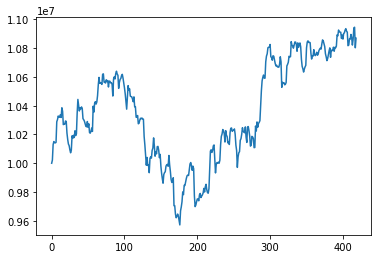

[10000000,
 10022293.842267282,
 10129690.12691041,
 10150676.440100279,
 10142951.943015832,
 10141409.968990201,
 10145079.836492056,
 10288560.44939859,
 10303843.43551797,
 10328384.984529717,
 10319964.513638139,
 10320321.980636349,
 10337675.481653834,
 10318345.362925777,
 10385821.179301096,
 10361511.717892494,
 10268621.363127809,
 10274775.733396864,
 10271641.4958985,
 10294037.386889458,
 10291128.340918107,
 10209851.885412395,
 10165810.867334375,
 10133515.882415013,
 10122453.873878011,
 10093789.787634807,
 10072612.142184949,
 10090801.444828821,
 10190889.804527266,
 10173121.876873052,
 10193946.475136869,
 10178991.637848005,
 10225679.068021059,
 10192256.298463246,
 10204882.394806739,
 10344878.917768914,
 10443833.048425432,
 10402545.83597613,
 10363630.064151037,
 10384988.645376494,
 10377771.34919198,
 10391573.938095389,
 10380265.633597802,
 10310152.407984719,
 10302720.231354654,
 10292156.499334516,
 10274053.26894715,
 10256478.452096716,
 10253453.

In [5]:
mwu(filename,'absolute','equal')

Final distribution:  [0.0974243  0.04415463 0.05137942 0.06690866 0.04113925 0.07567164
 0.03600839 0.06579414 0.09192974 0.06240865 0.02978495 0.03001393
 0.081419   0.05965755 0.08195727 0.01141311 0.0321829  0.04075247]
Final transaction count:  201 total cost:  766902.8984526669
starting value:  10000000 final value:  10911100.910291716 less transaction costs:  10144198.011839049
Return 1.4419801183904895 %


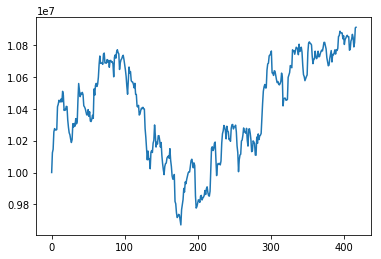

[10000000,
 10123899.857857266,
 10145394.418358214,
 10254602.293357933,
 10275484.975013338,
 10267287.425232546,
 10266068.35734092,
 10269621.498991888,
 10412545.657301268,
 10427951.908767115,
 10453136.472090248,
 10443646.291830562,
 10443299.41673429,
 10461594.185500707,
 10442600.54383176,
 10509165.426754644,
 10484911.996481156,
 10389290.710354112,
 10395490.22284503,
 10391442.919298533,
 10414870.702721542,
 10413297.249274664,
 10330635.733059438,
 10283404.332937147,
 10249142.387822375,
 10236656.336832365,
 10209099.273165554,
 10188181.847311744,
 10206209.97175239,
 10305911.703911727,
 10284946.818884997,
 10307616.981060803,
 10290753.262159528,
 10337906.760728134,
 10305019.399506833,
 10316994.039804406,
 10453007.592560166,
 10558213.937783603,
 10516946.09731674,
 10475797.39822396,
 10497207.797795102,
 10489205.816637665,
 10502479.045103064,
 10487241.102040693,
 10418869.259374024,
 10411428.663786646,
 10400392.685677327,
 10380326.8495609,
 10361570.7

In [81]:
mwu(filename,'pricerel','equal')

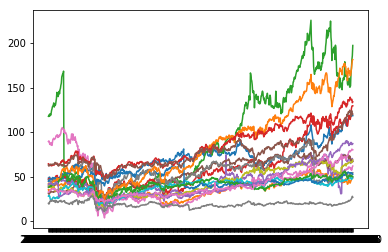

In [75]:
opening = pd.read_excel('lowvol_weekly.xlsx')[::-1].iloc[:,::2]
opening = opening.drop(['BRK.B_open'], axis=1)
plt.plot(opening)
plt.show()

In [82]:
d = (opening.iloc[-1] - opening.iloc[0])/opening.iloc[0]
d

WMT_open    1.457979
BK_open     0.377230
CI_open     0.676548
JPM_open    1.764831
DD_open     0.730868
CL_open     1.146506
HIG_open   -0.308501
AFL_open    0.180849
DOX_open    0.710112
BCE_open    0.731263
KO_open     0.182492
HON_open    3.316916
L_open      0.320655
PEP_open    1.083981
RSG_open    1.130382
PG_open     0.915419
SYY_open    1.458423
WU_open     0.341206
dtype: float64